In [4]:
from bs4 import BeautifulSoup
%matplotlib inline
import requests
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_context('notebook')
"""
Example usage:
>>> from data_mining import *
>>> mine_data('2009', 'B1', 'Spring')
...


Will output a dict containing a global data frame
The data frame is indexed by the the year, semester and sciper
"""

years = {
	'2007': '978181',
	'2008': '978187',
	'2009': '978195',
	'2010': '39486325',
	'2011': '123455150',
	'2012': '123456101',
	'2013': '213637754',
	'2014': '213637922',
	'2015': '213638028',
	'2016': '355925344'
}

semesters = {
	'B1': '249108',
    'B5': '942120',
	'B6': '942175',
	'M1': '2230106',
    'M2': '942192',
	'M3': '2230128',
	'PMAut': '249127',
	'PMSpr': '3781783'
}

indexes =  []

def get_url(year, semester):
    """Get the url corresponding to a given year and semester"""
    y, sem = years[year], semesters[semester]
    return 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=249847&ww_x_PERIODE_ACAD='+ y +'&ww_x_PERIODE_PEDAGO=' + sem + '&ww_x_HIVERETE=null'

def request(year, semester):
    """return the http request corresponding to a given year and semester"""
    url = get_url(year, semester)
    return requests.get(url, verify=False)

def get_soup(year, semester):
    """return the data soup (BeautifulSoup) corresponding to a given year and semester"""
    r = request(year, semester)
    data = r.text
    return BeautifulSoup(data,"lxml")


def get_table(soup, year, semester):
    """Transform the data soup into a dict containing the data frame
    Each dict contains the section, the year, and the dataframe containing all the corresponding data
    The dataframe contains all the columns returned by the html page + the index corresponding to "indexes"
    """
    global indexes
    table = soup.html.body.table ##get to the table
    list_df  = [] ##init list of data frame
    tc = table.children ##every rows of the table
    first_row = next(tc, None)
    attrs = first_row.text.split(',') ##extract the attributes from the header row
    #section = attrs[0]
    #year = attrs[1]
    nb_student = int(attrs[2].split("(")[1].split(" ")[0])
    if nb_student != 0: ##next row should contain columns info (except if there is no student)
        next_row = next(tc, None) ##directly iterate our iterator the next row
        columns = list(map(lambda l: l.text, next_row.children)) ##transform the children into a list of the inner text of each children
        df = pd.DataFrame(columns=columns) ##create the data frame with the columns from this list

        for c in tc:
            t = list(map(lambda l: l.text, c.children))[:-1] ##transform the children into a list of the inner text of each children (corresponding here to each column)
            df.loc[df.shape[0]] = t ##append the data to the last dataframe created

        sciper_c = columns[-1]
        df = df.set_index([sciper_c, 'Nom Prénom'])
        df[semester+'_year'] = year 
    
        return df
    return pd.DataFrame()

def mine_data(year, semester):
    soup = get_soup(year, semester) ##get the soup
    return get_table(soup, year, semester) ##process the soup


In [6]:
df_bachelor =  mine_data('2007', 'B1')
df_bachelor['B5_year'] = float('NaN')
df_bachelor['B6_year'] = float('NaN')

for year in range(2007, 2017):
    df_b1 = mine_data(str(year), 'B1')
    #override only if B1 is not in the dataframe yet
    df_bachelor = df_bachelor.combine_first(df_b1)
    
    #override the date when older semester found
    df_b6 = mine_data(str(year), 'B6')
    df_b5 = mine_data(str(year), 'B5')
    df_bachelor.update(df_b6)
    df_bachelor.update(df_b5)

In [7]:
df_bachelor

,,B1_year,B5_year,B6_year,Civilité,Ecole Echange,Filière opt.,Mineur,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,
147008,Good Xavier,2008,2010,2010,Monsieur,Carnegie Mellon University Pittsburgh,,,,,,Congé,Bilatéral
161212,Tamesna Rachid,2009,NaN,NaN,Monsieur,,,,,,,Présent,
169569,Arévalo Christian,2007,2009,2009,Monsieur,,,,,,,Présent,
169731,Knecht Mathieu,2007,2010,2010,Monsieur,,,,,,,Congé,
169795,Scheiben Pascal,2007,2011,2010,Monsieur,,,,,,,Présent,
170509,Grall Jean-Louis,2007,NaN,NaN,Monsieur,,,,,,,Présent,
171195,Richter Arnaud,2007,2009,2009,Monsieur,,,,,,,Présent,
171568,Villavicencio Omar,2007,NaN,NaN,Monsieur,,,,,,,Présent,
171619,Buchschacher Nicolas,2007,2009,2009,Monsieur,,,,,,,Présent,


Now we keep the rows which have a value in B1 and B6

In [8]:
df_bachelor = df_bachelor.dropna(subset=['B1_year', 'B6_year'])
df_bachelor

,,B1_year,B5_year,B6_year,Civilité,Ecole Echange,Filière opt.,Mineur,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,
147008,Good Xavier,2008,2010,2010,Monsieur,Carnegie Mellon University Pittsburgh,,,,,,Congé,Bilatéral
169569,Arévalo Christian,2007,2009,2009,Monsieur,,,,,,,Présent,
169731,Knecht Mathieu,2007,2010,2010,Monsieur,,,,,,,Congé,
169795,Scheiben Pascal,2007,2011,2010,Monsieur,,,,,,,Présent,
171195,Richter Arnaud,2007,2009,2009,Monsieur,,,,,,,Présent,
171619,Buchschacher Nicolas,2007,2009,2009,Monsieur,,,,,,,Présent,
174905,Aubelle Flavien,2007,2011,2011,Monsieur,,,,,,,Présent,
175190,Hanser Valérian,2007,2010,2009,Monsieur,,,,,,,Présent,
175280,Uberti Quentin,2007,2010,2010,Monsieur,,,,,,,Présent,


Bachelor 6 is actually in the spring semester so one year after

In [9]:
df_bachelor[['B6_year']] = df_bachelor[['B6_year']].apply(pd.to_numeric)
df_bachelor['B6_year'] = df_bachelor['B6_year'] + 1

/Users/prisca/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/prisca/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [10]:
df_bachelor

,,B1_year,B5_year,B6_year,Civilité,Ecole Echange,Filière opt.,Mineur,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,
147008,Good Xavier,2008,2010,2011,Monsieur,Carnegie Mellon University Pittsburgh,,,,,,Congé,Bilatéral
169569,Arévalo Christian,2007,2009,2010,Monsieur,,,,,,,Présent,
169731,Knecht Mathieu,2007,2010,2011,Monsieur,,,,,,,Congé,
169795,Scheiben Pascal,2007,2011,2011,Monsieur,,,,,,,Présent,
171195,Richter Arnaud,2007,2009,2010,Monsieur,,,,,,,Présent,
171619,Buchschacher Nicolas,2007,2009,2010,Monsieur,,,,,,,Présent,
174905,Aubelle Flavien,2007,2011,2012,Monsieur,,,,,,,Présent,
175190,Hanser Valérian,2007,2010,2010,Monsieur,,,,,,,Présent,
175280,Uberti Quentin,2007,2010,2011,Monsieur,,,,,,,Présent,


In [11]:
def compute_time(df):
    #if the student finishes in the fifth semester, it has done six more months 
    if float(df['B5_year']) >= float(df['B6_year']):
        end = float(df['B5_year']) + 0.5
    #otherwise he finishes in the summer
    else:
        end = float(df['B6_year'])
    time = end - float(df['B1_year'])
    return time

In [12]:
df_bachelor['bachelor_years'] = df_bachelor.apply(compute_time, axis=1)

/Users/prisca/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
df_bachelor

,,B1_year,B5_year,B6_year,Civilité,Ecole Echange,Filière opt.,Mineur,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,bachelor_years
No Sciper,Nom Prénom,,,,,,,,,,,,,
147008,Good Xavier,2008,2010,2011,Monsieur,Carnegie Mellon University Pittsburgh,,,,,,Congé,Bilatéral,3.0
169569,Arévalo Christian,2007,2009,2010,Monsieur,,,,,,,Présent,,3.0
169731,Knecht Mathieu,2007,2010,2011,Monsieur,,,,,,,Congé,,4.0
169795,Scheiben Pascal,2007,2011,2011,Monsieur,,,,,,,Présent,,4.5
171195,Richter Arnaud,2007,2009,2010,Monsieur,,,,,,,Présent,,3.0
171619,Buchschacher Nicolas,2007,2009,2010,Monsieur,,,,,,,Présent,,3.0
174905,Aubelle Flavien,2007,2011,2012,Monsieur,,,,,,,Présent,,5.0
175190,Hanser Valérian,2007,2010,2010,Monsieur,,,,,,,Présent,,3.5
175280,Uberti Quentin,2007,2010,2011,Monsieur,,,,,,,Présent,,4.0


We simply need to group by `Civilité` to get the average time per gender

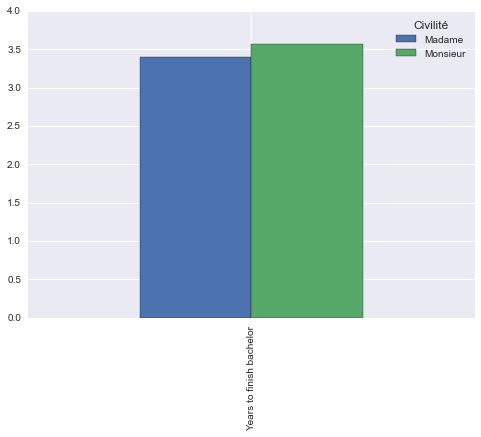

In [14]:
df_bachelor["Civilité"].astype('category')
sex_grouped = df_bachelor.groupby('Civilité')['bachelor_years']
b_years = sex_grouped.apply(np.average)
b_years.to_frame(name='Years to finish bachelor').unstack().unstack().plot.bar()

Check if it is statistically significant

# TODO

# Question 2 

Get the data

In [15]:
df_master =  mine_data('2007', 'M1')
df_master['M1_year'] = float('NaN')
df_master['M2_year'] = float('NaN')
df_master['M3_year'] = float('NaN')
df_master['PMAut_year'] = float('NaN')
df_master['PMSpr_year'] = float('NaN')
df_master['Spécialisation'] = str('NaN')

for year in range(2007, 2017):
    df_m1 = mine_data(str(year), 'M1')
    #override only if B1 is not in the dataframe yet
    df_master = df_master.combine_first(df_m1)
    
    #override the date when older semester found
    df_m2 = mine_data(str(year), 'M2')
    df_m3 = mine_data(str(year), 'M3')
    df_p1 = mine_data(str(year), 'PMAut')
    df_p2 = mine_data(str(year), 'PMSpr')
    df_master.update(df_m2)
    df_master.update(df_m3)
    df_master.update(df_p1)
    df_master.update(df_p2)

In [16]:
df_master

,,Civilité,Ecole Echange,Filière opt.,M1_year,M2_year,M3_year,Mineur,Orientation Bachelor,Orientation Master,PMAut_year,PMSpr_year,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,,,
138088,Droz-dit-Busset Arnault,Monsieur,,,2007.0,NaN,NaN,,,,NaN,NaN,NaN,Présent,
146330,Cardinaux Damien,Monsieur,,,2007.0,2007,2008,,,,NaN,NaN,,Présent,
146742,Marx Clément,Monsieur,,,2008.0,2009,2012,,,,2010,2010,"Signals, Images and Interfaces",Présent,
146929,Junod Antoine,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,
147008,Good Xavier,Monsieur,,,2011.0,2012,2012,,,,NaN,NaN,,Présent,
152232,Anagnostaras David,Monsieur,,,2007.0,2007,2008,"Mineur en Management, technologie et entrepren...",,,NaN,NaN,,Présent,
153066,Aeberhard François-Xavier,Monsieur,,,2007.0,2009,2009,,,,NaN,NaN,Internet computing,Présent,
153746,Cassina Ilya,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,
153762,Conus Johann,Monsieur,,,2008.0,2009,2009,,,,NaN,NaN,,Présent,


Drop the ones without M1 and M2 entries

In [17]:
df_m = df_master.dropna(subset=['M1_year', 'M2_year'])

In [18]:
df_m

,,Civilité,Ecole Echange,Filière opt.,M1_year,M2_year,M3_year,Mineur,Orientation Bachelor,Orientation Master,PMAut_year,PMSpr_year,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,,,
146330,Cardinaux Damien,Monsieur,,,2007.0,2007,2008,,,,NaN,NaN,,Présent,
146742,Marx Clément,Monsieur,,,2008.0,2009,2012,,,,2010,2010,"Signals, Images and Interfaces",Présent,
146929,Junod Antoine,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,
147008,Good Xavier,Monsieur,,,2011.0,2012,2012,,,,NaN,NaN,,Présent,
152232,Anagnostaras David,Monsieur,,,2007.0,2007,2008,"Mineur en Management, technologie et entrepren...",,,NaN,NaN,,Présent,
153066,Aeberhard François-Xavier,Monsieur,,,2007.0,2009,2009,,,,NaN,NaN,Internet computing,Présent,
153746,Cassina Ilya,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,
153762,Conus Johann,Monsieur,,,2008.0,2009,2009,,,,NaN,NaN,,Présent,
154080,Fomene Tierry Alain,Monsieur,,,2007.0,2008,2009,,,,NaN,NaN,Internet computing,Présent,


To compute stay:
-if PMAut_year or PMSpr_year is not empty, then this is the last value - M1_year
-if M3_year 

# TODO delete rows with Mineur and not M3_year

In [25]:
#df_m[((df_m.Mineur != '') and (df_m.M3_year > 0)) | (df_m.Mineur == '')]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [48]:
df_m[['M1_year','M2_year','M3_year','PMAut_year','PMSpr_year']] = df_m[['M1_year','M2_year','M3_year','PMAut_year','PMSpr_year']].apply(pd.to_numeric)

/Users/prisca/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [36]:
df_m

,,Civilité,Ecole Echange,Filière opt.,M1_year,M2_year,M3_year,Mineur,Orientation Bachelor,Orientation Master,PMAut_year,PMSpr_year,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,,,
146330,Cardinaux Damien,Monsieur,,,2007.0,2007,2008.0,,,,NaN,NaN,,Présent,
146742,Marx Clément,Monsieur,,,2008.0,2009,2012.0,,,,2010.0,2010.0,"Signals, Images and Interfaces",Présent,
146929,Junod Antoine,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,
147008,Good Xavier,Monsieur,,,2011.0,2012,2012.0,,,,NaN,NaN,,Présent,
152232,Anagnostaras David,Monsieur,,,2007.0,2007,2008.0,"Mineur en Management, technologie et entrepren...",,,NaN,NaN,,Présent,
153066,Aeberhard François-Xavier,Monsieur,,,2007.0,2009,2009.0,,,,NaN,NaN,Internet computing,Présent,
153746,Cassina Ilya,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,
153762,Conus Johann,Monsieur,,,2008.0,2009,2009.0,,,,NaN,NaN,,Présent,
154080,Fomene Tierry Alain,Monsieur,,,2007.0,2008,2009.0,,,,NaN,NaN,Internet computing,Présent,


In [49]:
def compute_time_master(df):
    #if the student has done a master project 
    if (not pd.isnull(df['PMAut_year'])):
        end = float(df['PMAut_year']) + 0.5
    elif (not pd.isnull(df['PMSpr_year'])):
        end = float(df['PMSpr_year']) + 1
    elif (not pd.isnull(df['M3_year'])):
        end = float(df['M3_year']) + 0.5
    else:
        end = float(df['M2_year']) + 1
    time = float(end) - float(df['M1_year'])
    return time

In [50]:
df_m['master_years'] = df_m.apply(compute_time_master, axis=1)

/Users/prisca/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [51]:
df_m

,,Civilité,Ecole Echange,Filière opt.,M1_year,M2_year,M3_year,Mineur,Orientation Bachelor,Orientation Master,PMAut_year,PMSpr_year,Spécialisation,Statut,Type Echange,master_years
No Sciper,Nom Prénom,,,,,,,,,,,,,,,
146330,Cardinaux Damien,Monsieur,,,2007.0,2007,2008.0,,,,NaN,NaN,,Présent,,1.5
146742,Marx Clément,Monsieur,,,2008.0,2009,2012.0,,,,2010.0,2010.0,"Signals, Images and Interfaces",Présent,,2.5
146929,Junod Antoine,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,,1.0
147008,Good Xavier,Monsieur,,,2011.0,2012,2012.0,,,,NaN,NaN,,Présent,,1.5
152232,Anagnostaras David,Monsieur,,,2007.0,2007,2008.0,"Mineur en Management, technologie et entrepren...",,,NaN,NaN,,Présent,,1.5
153066,Aeberhard François-Xavier,Monsieur,,,2007.0,2009,2009.0,,,,NaN,NaN,Internet computing,Présent,,2.5
153746,Cassina Ilya,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,,1.0
153762,Conus Johann,Monsieur,,,2008.0,2009,2009.0,,,,NaN,NaN,,Présent,,1.5
154080,Fomene Tierry Alain,Monsieur,,,2007.0,2008,2009.0,,,,NaN,NaN,Internet computing,Présent,,2.5


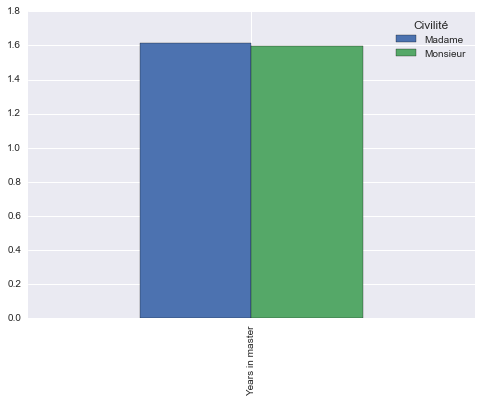

In [55]:
df_m["Civilité"].astype('category')
sex_grouped_master = df_m.groupby('Civilité')['master_years']
m_years = sex_grouped_master.apply(np.average)
m_years.to_frame(name='Years in master').unstack().unstack().plot.bar()

Now we look at the Spécialisation

In [63]:
df_spec = df_m[df_m['Spécialisation'] != '']

In [64]:
df_spec

,,Civilité,Ecole Echange,Filière opt.,M1_year,M2_year,M3_year,Mineur,Orientation Bachelor,Orientation Master,PMAut_year,PMSpr_year,Spécialisation,Statut,Type Echange,master_years
No Sciper,Nom Prénom,,,,,,,,,,,,,,,
146742,Marx Clément,Monsieur,,,2008.0,2009,2012.0,,,,2010.0,2010.0,"Signals, Images and Interfaces",Présent,,2.5
153066,Aeberhard François-Xavier,Monsieur,,,2007.0,2009,2009.0,,,,NaN,NaN,Internet computing,Présent,,2.5
154080,Fomene Tierry Alain,Monsieur,,,2007.0,2008,2009.0,,,,NaN,NaN,Internet computing,Présent,,2.5
154573,Benabdallah Zeineb,Madame,,,2007.0,2008,2009.0,,,,NaN,2009.0,Biocomputing,Présent,,3.0
159998,Jesse Julia,Madame,,,2008.0,2008,2009.0,,,,NaN,NaN,"Signals, Images and Interfaces",Présent,,1.5
160254,Kohler Johann,Monsieur,,,2007.0,2007,2008.0,,,,NaN,NaN,Internet computing,Présent,,1.5
160718,Copponnex Hadrien,Monsieur,,,2007.0,2007,2008.0,,,,NaN,NaN,Foundations of Software,Présent,,1.5
160991,Schintgen Joël,Monsieur,,,2007.0,2007,2008.0,,,,NaN,NaN,Internet computing,Présent,,1.5
161357,Gfeller Sebastian,Monsieur,,,2007.0,2007,2008.0,,,,NaN,NaN,Foundations of Software,Présent,,1.5


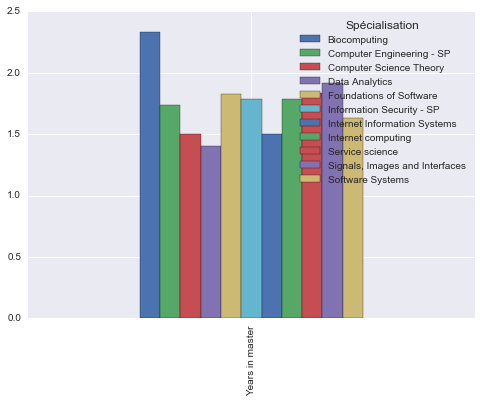

In [67]:
df_spec["Spécialisation"].astype('category')
spec_grouped_master = df_spec.groupby('Spécialisation')['master_years']
m_spec = spec_grouped_master.apply(np.average)
m_spec.to_frame(name='Years in master').unstack().unstack().plot.bar()
